# ASR Punctuation Restoration Experiments
By Bart Pleiter S4752740 for the course ASR 2021-2022

## Imports and setup

In [1]:
# imports
import os
import re
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import random

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras import mixed_precision
import tensorflow_addons as tfa
from tensorflow.keras.utils import Sequence
import tensorflow.keras.backend as kb

from transformers import BertTokenizer
from transformers import TFBertModel

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import more_itertools as mit

In [2]:
# use mixed precision to speed up training on my RTX3050
mixed_precision.set_global_policy('mixed_float16')

memoryLimit = 6500 # 6.5GB to leave some free memory for other processes

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memoryLimit)]
        )
    except RuntimeError as e:
        print(e)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3050, compute capability 8.6


## Hyperparameters

In [3]:
# flags
RETRAIN_MODEL = False # retrain the model if true, else load weights from checkpoint

# hyperparameters
batchSize = 32 # batch size
numLabels = 4 # number of labels for each token
seqLen = 64 # sequence length to give to BERT (max 512)
dropout = 0.5 # dropout amount for the dropout layers
learningRate = 1e-5 # learning rate during training
epochs = 3 # number of epochs for the training process
seqShift = 8 # length of sequence shifting for creating the inputs (lower = more predictions per token)

# labels
LABEL_NOTHING = 0
LABEL_COMMA = 1
LABEL_PERIOD = 2
LABEL_QUESTION = 3
labelNames = ["O", "COMMA", "PERIOD", "QUESTION"]

# encode the punctuation label as a number
punctEncode = {
    "O": LABEL_NOTHING,
    "COMMA": LABEL_COMMA,
    "PERIOD": LABEL_PERIOD,
    "QUESTION": LABEL_QUESTION
}

# decode the label for printing purposes
punctDecode = {v: k for k, v in punctEncode.items()}

# path of datasets (add / at the end)
dataPath = "IWSLTche/Data/" # for Nagy et al. research: "IWSLT2012/Data/"

# which BERT network to use
modelName = "bert-base-uncased"

# setup BERT and its tokenizer
tokenizer = BertTokenizer.from_pretrained(modelName)
bert_layer = TFBertModel.from_pretrained(modelName)

# setup checkpoints
checkpoint_path = "checkpoints/IWSLTcheBERTbaseUncased_{epoch:02d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_best_only=False)

# which checkpoint to restore if RETRAIN_MODEL is false
checkpointPath = "checkpoints/IWSLTcheBERTbaseUncased_01.ckpt" #tf.train.latest_checkpoint(checkpoint_dir)

2022-05-30 17:32:30.146537: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-30 17:32:30.615490: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6500 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050, pci bus id: 0000:07:00.0, compute capability: 8.6
Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are i

## Dataset preparation

Loads a preprocessed dataset from file and creats chunks with overlap.
See other notebooks (like IWSLTchePrepare.ipynb) for the preprocessing steps!

In [4]:
# read the processed dataset from file
# also create chunks of seqLen with padding
# padding works as follows:
#  to give each token the same amount of predictions, padding of seqLen-1 will be applied
#  to both the start and end of the data
def getPreparedDataset(prefix, shift=True):
    def padAndChunkWindowed(data):
        data = np.pad(data, (seqLen-1, seqLen-1), mode='constant')
        return np.array(list(mit.windowed(data, seqLen, fillvalue=0, step=seqShift)), dtype="int32")

    with open(dataPath + modelName + "/" + prefix + "_data.pkl", 'rb') as f:
        X, Y = pickle.load(f)
    
    if shift:
        return padAndChunkWindowed(X), padAndChunkWindowed(Y), len(Y)
    else:
        return X, Y, len(Y)

trainX, trainY, lenTrain = getPreparedDataset("train")
valX, valY, lenVal = getPreparedDataset("valid")
testX, testY, lenTest = getPreparedDataset("test")
testAsrX, testAsrY, lenTestAsr = getPreparedDataset("testasr")

In [5]:
print(trainX.shape, lenTrain)
print(valX.shape, lenVal)
print(testX.shape, lenTest)
print(testAsrX.shape, lenTestAsr)

(284884, 64) 2279001
(40160, 64) 321207
(1706, 64) 13578
(1709, 64) 13596


## Model creation

In [6]:
# custom loss function which replaces the -1 labels and predictions at that place with 0
#  to exclude subwords from calculating the loss
#  and so it can be used to calculate the sparse categorical crossentropy, which does not work with -1
def customSparseCategoricalCrossEntropy(y_actual,y_pred):
    y_actual = tf.where(y_actual == -1, 0, y_actual)
    y_pred = tf.boolean_mask(y_pred, y_actual != -1)
    loss=kb.sparse_categorical_crossentropy(y_actual, y_pred)
    
    # mean is not really needed
    #loss=kb.mean(loss, axis=-1)
    #loss=kb.mean(loss, axis=-1)
    
    return loss

In [7]:
# model construction

# input layer (batchSize, seqLen)
bert_input = tf.keras.Input(shape=(seqLen), dtype='int32', name='bert_input')

# get embeddings for each token from BERT layer (batchSize, seqLen, 768)
x = bert_layer(bert_input)[0]

# do dropout
x = tf.keras.layers.Dropout(dropout, name="dropout1")(x)

# fully connected layer 768 -> 768x2
x = tf.keras.layers.Dense(1536, name='linearExtra')(x)

# do dropout
x = tf.keras.layers.Dropout(dropout, name="dropoutExtra")(x)

# relu activation on fully connected layer output
x = tf.keras.layers.Activation('relu', name='relu')(x)

# fully connected output layer
x = tf.keras.layers.Dense(numLabels, name='linear')(x)

# softmax activation on output layer
model_out = tf.keras.layers.Activation('sigmoid', dtype='float32', name='softmax')(x)

model = tf.keras.Model(inputs=bert_input, outputs=model_out, name='model')
model.compile(
    tf.keras.optimizers.Adam(learning_rate=learningRate),
    loss=customSparseCategoricalCrossEntropy,
    metrics=tf.keras.metrics.SparseCategoricalAccuracy()
)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert_input (InputLayer)     [(None, 64)]              0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             64, 768),                           
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

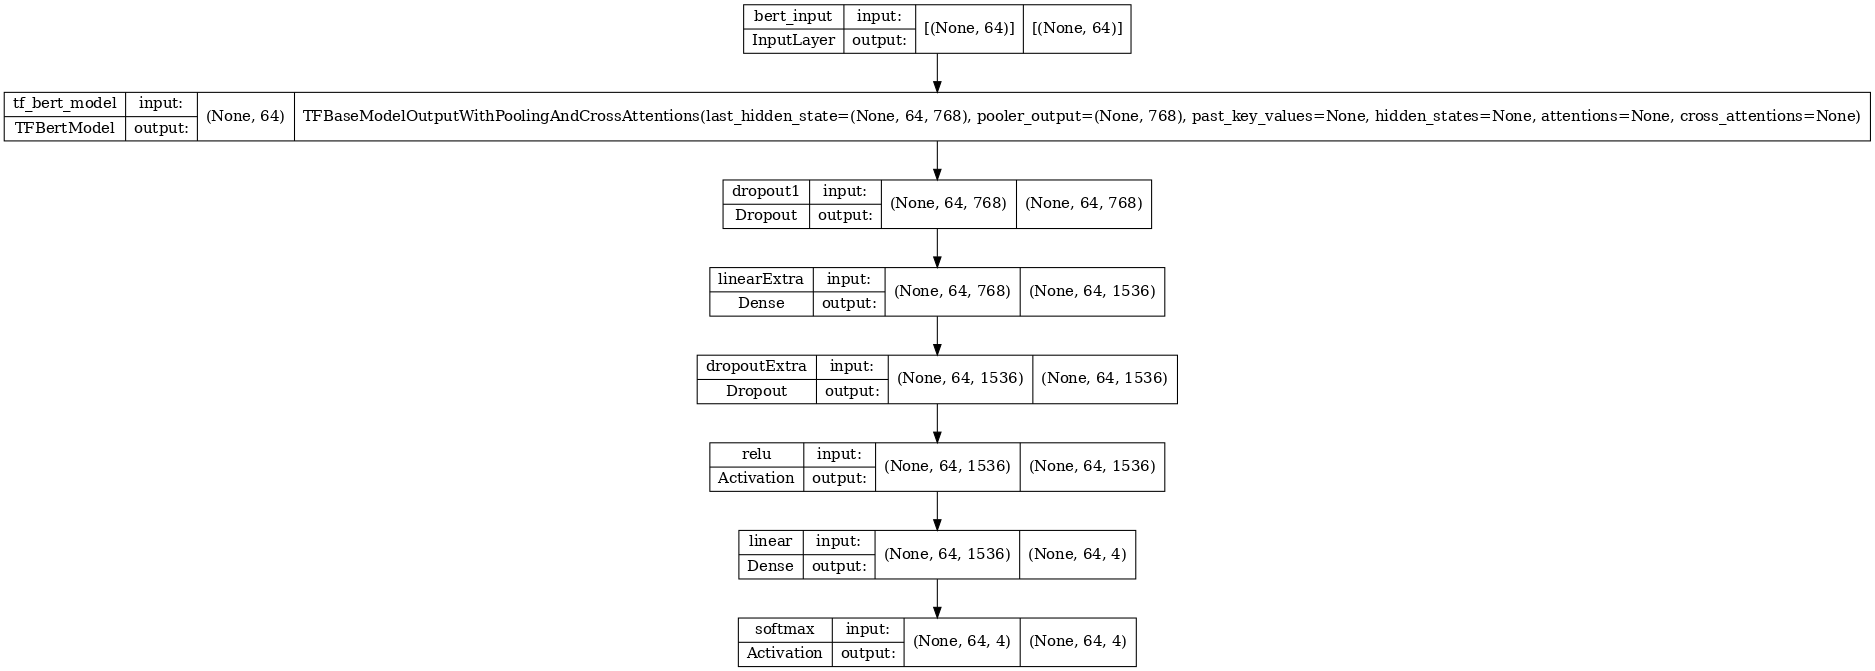

In [8]:
# plot the model architecture
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, dpi=76)

## Training

In [9]:
if RETRAIN_MODEL:
    # training the data
    history = model.fit(
        trainX, trainY,
        #validation_split=0.2,
        epochs=epochs,
        shuffle=True,
        batch_size=batchSize,
        validation_data=(valX, valY),
        callbacks=[cp_callback]#tf.keras.callbacks.EarlyStopping(monitor='val_loss', verbose=1, patience=2)
    )
else:
    model.load_weights(checkpointPath)

In [10]:
if RETRAIN_MODEL:
    # show the fitting history
    history.history

    # plot the loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

## Basic Evaluation
- Precision, Recall and F1 per class
- Confusion Matrix

In [11]:
# to obtain the indexes of a token in all predictions containing the token
predictionsPerToken = seqLen // seqShift
def getIndexOfPrediction(i):
    x = []
    y = []
    x0 = seqLen - (seqShift-(i-1) % seqShift)
    y0 = (seqShift-1 + i) // seqShift
    for p in range(predictionsPerToken):
        x.append(x0 - p*predictionsPerToken)
        y.append(y0 + p)
    
    return y, x

In [12]:
# evaluates the predicted results
# by taking the mean of multiple predictions from the sliding window
# and removing the subwords from data (indicated by the -1 true label)
def evaluateResults(Ytrue, Ypred, lenData, title):
    
    noWindowYtrue = []
    noWindowYpred = []
    
    for i in range(lenData):
        ylist, xlist = getIndexOfPrediction(i)
        predValues = []
        # add the prediction for each token
        for n in range(len(ylist)):
            predValues.append(Ypred[ylist[n]][xlist[n]])
        
        # add the true label for the current token
        noWindowYtrue.append(Ytrue[ylist[0]][xlist[0]])
                
        # take the mean of each prediction
        predValues = np.array(np.mean(predValues, axis=0))
        
        noWindowYpred.append(predValues)
        
    # select best class for each token
    noWindowYpred = np.array(noWindowYpred).argmax(axis=-1)    
    
    # apply mask to ignore (remove) subwords from the arrays
    noWindowYtrue = np.array(noWindowYtrue)
    wordMask = noWindowYtrue != -1
    Ypred = noWindowYpred[wordMask]
    Ytrue = np.array(noWindowYtrue[wordMask])
    
    print(classification_report(Ytrue, Ypred, target_names=labelNames))
    
    confusionMatrix = confusion_matrix(Ytrue, Ypred, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=confusionMatrix, display_labels=labelNames)
    print("Confusion matrix:")
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()
    
    return classification_report(Ytrue, Ypred, target_names=labelNames, output_dict=True)

# Validation set

In [13]:
# generate output on validation data
valPredict = model.predict(valX)

              precision    recall  f1-score   support

           O       0.98      0.99      0.98    253908
       COMMA       0.75      0.65      0.69     22396
      PERIOD       0.79      0.84      0.81     18871
    QUESTION       0.74      0.76      0.75      1489

    accuracy                           0.95    296664
   macro avg       0.81      0.81      0.81    296664
weighted avg       0.95      0.95      0.95    296664

Confusion matrix:


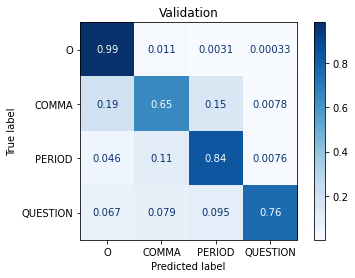

In [14]:
_ = evaluateResults(valY, valPredict, lenVal, "Validation")

# Test set

In [15]:
# generate output on test data
testPredict = model.predict(testX)

              precision    recall  f1-score   support

           O       0.99      0.99      0.99     10984
       COMMA       0.74      0.70      0.72       830
      PERIOD       0.81      0.88      0.85       806
    QUESTION       0.80      0.87      0.83        46

    accuracy                           0.96     12666
   macro avg       0.84      0.86      0.85     12666
weighted avg       0.96      0.96      0.96     12666

Confusion matrix:


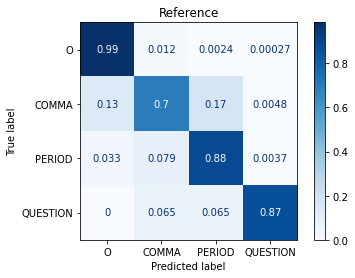

In [16]:
_ = evaluateResults(testY, testPredict, lenTest, "Reference")

In [17]:
# generate output on test ASR data
testAsrPredict = model.predict(testAsrX)

              precision    recall  f1-score   support

           O       0.98      0.96      0.97     11207
       COMMA       0.53      0.62      0.57       798
      PERIOD       0.73      0.81      0.77       809
    QUESTION       0.51      0.66      0.57        35

    accuracy                           0.93     12849
   macro avg       0.69      0.76      0.72     12849
weighted avg       0.94      0.93      0.93     12849

Confusion matrix:


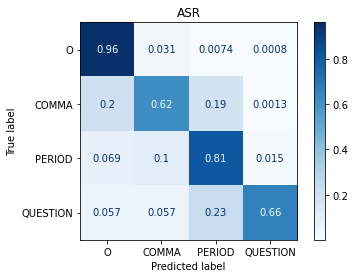

In [18]:
_ = evaluateResults(testAsrY, testAsrPredict, lenTestAsr, "ASR")

## Adding ASR errors

In [19]:
# get the value for the special unknown token (should be 100 in case of BERT tokenizer)
UNK = tokenizer.convert_tokens_to_ids(['[UNK]'])[0]
print(UNK)

100


In [20]:
# same as getPreparedDataset, but adds ASR-like errors based on Alam et al. (2020) data augmentation method
# for the alpha parameters we multiplied the values from the thesis with 100 to get percentages
def getASRerroredPreparedDataset(prefix, alpha, aSub, aDel, aIns):
    
    def addASRlikeErrors(X, Y, alpha, aSub, aDel, aIns):

        # loop through all tokens (backwards, so we do not mess up indexes)
        i = len(Y)
        while i > 0:
            i-=1
            
            # do action with probability alpha
            if random.random() < alpha:
                # select action
                action = random.choices(["sub", "del", "ins"], weights=(aSub, aDel, aIns), k=1)[0]
                
                # replace token with [UNK]
                if action == "sub":
                    X[i] = UNK
                # delete token and label
                elif action == "del":
                    del X[i]
                    del Y[i]
                # insert [UNK] token with label O
                elif action == "ins":
                    X.insert(i, UNK)
                    Y.insert(i, LABEL_NOTHING)
                else:
                    raise ValueError("Did not generate an action")
        
        return X, Y
    
    def padAndChunkWindowed(data):
        data = np.pad(data, (seqLen-1, seqLen-1), mode='constant')
        return np.array(list(mit.windowed(data, seqLen, fillvalue=0, step=seqShift)), dtype="int32")

    with open(dataPath + modelName + "/" + prefix + "_data.pkl", 'rb') as f:
        X, Y = pickle.load(f)
        Xerr, Yerr = addASRlikeErrors(X, Y, alpha, aSub, aDel, aIns)
    return padAndChunkWindowed(Xerr), padAndChunkWindowed(Yerr), len(Yerr), X

              precision    recall  f1-score   support

           O       0.99      0.99      0.99     10984
       COMMA       0.74      0.70      0.72       830
      PERIOD       0.81      0.88      0.85       806
    QUESTION       0.80      0.87      0.83        46

    accuracy                           0.96     12666
   macro avg       0.84      0.86      0.85     12666
weighted avg       0.96      0.96      0.96     12666

Confusion matrix:


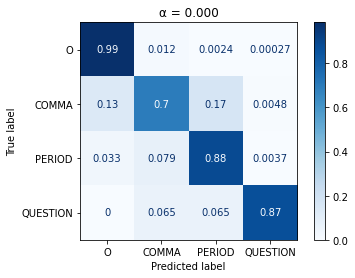

              precision    recall  f1-score   support

           O       0.99      0.97      0.98     10930
       COMMA       0.66      0.68      0.67       823
      PERIOD       0.77      0.87      0.82       797
    QUESTION       0.71      0.80      0.76        46

    accuracy                           0.95     12596
   macro avg       0.78      0.83      0.80     12596
weighted avg       0.95      0.95      0.95     12596

Confusion matrix:


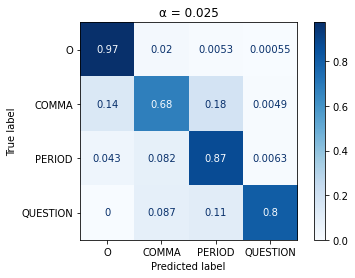

              precision    recall  f1-score   support

           O       0.98      0.96      0.97     10897
       COMMA       0.56      0.66      0.61       816
      PERIOD       0.72      0.84      0.78       793
    QUESTION       0.69      0.78      0.73        45

    accuracy                           0.93     12551
   macro avg       0.74      0.81      0.77     12551
weighted avg       0.94      0.93      0.93     12551

Confusion matrix:


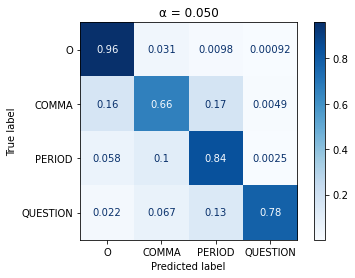

              precision    recall  f1-score   support

           O       0.98      0.95      0.96     10886
       COMMA       0.50      0.66      0.57       812
      PERIOD       0.69      0.82      0.75       784
    QUESTION       0.67      0.74      0.70        46

    accuracy                           0.92     12528
   macro avg       0.71      0.79      0.74     12528
weighted avg       0.93      0.92      0.92     12528

Confusion matrix:


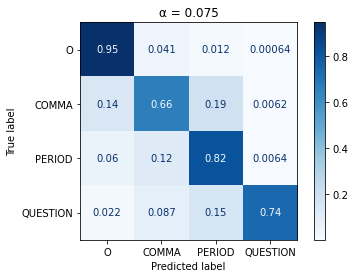

              precision    recall  f1-score   support

           O       0.98      0.93      0.96     10806
       COMMA       0.46      0.63      0.53       800
      PERIOD       0.66      0.83      0.74       773
    QUESTION       0.54      0.73      0.62        45

    accuracy                           0.91     12424
   macro avg       0.66      0.78      0.71     12424
weighted avg       0.93      0.91      0.91     12424

Confusion matrix:


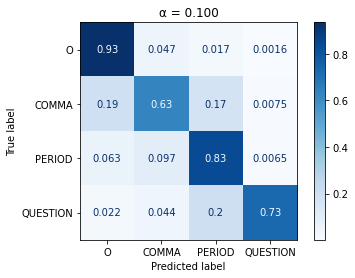

              precision    recall  f1-score   support

           O       0.98      0.92      0.95     10747
       COMMA       0.43      0.64      0.52       787
      PERIOD       0.62      0.79      0.69       772
    QUESTION       0.46      0.80      0.59        40

    accuracy                           0.90     12346
   macro avg       0.62      0.79      0.69     12346
weighted avg       0.92      0.90      0.91     12346

Confusion matrix:


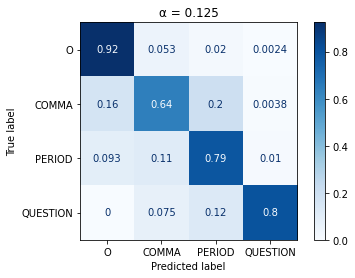

              precision    recall  f1-score   support

           O       0.97      0.91      0.94     10666
       COMMA       0.36      0.59      0.44       769
      PERIOD       0.58      0.77      0.66       760
    QUESTION       0.47      0.70      0.57        40

    accuracy                           0.88     12235
   macro avg       0.60      0.74      0.65     12235
weighted avg       0.91      0.88      0.89     12235

Confusion matrix:


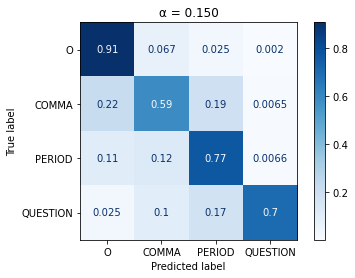

              precision    recall  f1-score   support

           O       0.98      0.90      0.93     10660
       COMMA       0.35      0.59      0.44       772
      PERIOD       0.52      0.75      0.62       746
    QUESTION       0.36      0.50      0.42        42

    accuracy                           0.87     12220
   macro avg       0.55      0.68      0.60     12220
weighted avg       0.91      0.87      0.88     12220

Confusion matrix:


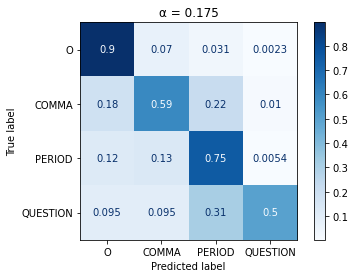

              precision    recall  f1-score   support

           O       0.97      0.89      0.93     10583
       COMMA       0.32      0.55      0.40       769
      PERIOD       0.51      0.74      0.60       740
    QUESTION       0.39      0.64      0.49        44

    accuracy                           0.86     12136
   macro avg       0.55      0.70      0.61     12136
weighted avg       0.90      0.86      0.88     12136

Confusion matrix:


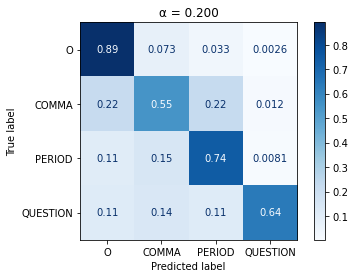

In [21]:
# evaluate on reference test data with an increasing amount of asr error added
alphaList = [0.0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.20]
ExpResults = [] # output metrics

# output for reconstructing text
ExpTokens = []
ExpLengths = []
ExpOutputs = []

for a in alphaList:
    # add errors to data
    ExpX, ExpY, lenExp, noWindowX = getASRerroredPreparedDataset("test", a, 40, 40, 20)
    ExpTokens.append(noWindowX)
    ExpLengths.append(lenExp)
    
    # pass data through the model
    ExpPredict = model.predict(ExpX)
    ExpOutputs.append(ExpPredict)
    
    # evaluate
    ExpResults.append(evaluateResults(ExpY, ExpPredict, lenExp, "α = " + "{:.{}f}".format(a,3)))

In [22]:
# Organizing results for easy plotting
Oprecision, Orecall, Of1 = [],[],[]
COMMAprecision, COMMArecall, COMMAf1 = [],[],[]
PERIODprecision, PERIODrecall, PERIODf1 = [],[],[]
Qprecision, Qrecall, Qf1 = [],[],[]

for result in ExpResults:
    Oprecision.append(result['O']['precision'])
    Orecall.append(result['O']['recall'])
    Of1.append(result['O']['f1-score'])
    
    COMMAprecision.append(result['COMMA']['precision'])
    COMMArecall.append(result['COMMA']['recall'])
    COMMAf1.append(result['COMMA']['f1-score'])
    
    PERIODprecision.append(result['PERIOD']['precision'])
    PERIODrecall.append(result['PERIOD']['recall'])
    PERIODf1.append(result['PERIOD']['f1-score'])
    
    Qprecision.append(result['QUESTION']['precision'])
    Qrecall.append(result['QUESTION']['recall'])
    Qf1.append(result['QUESTION']['f1-score'])

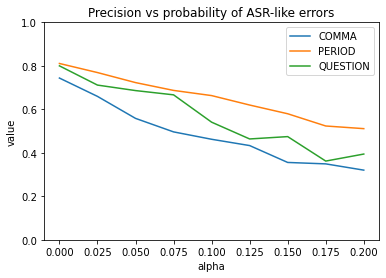

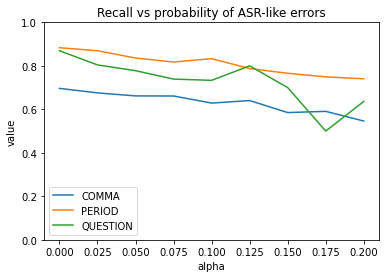

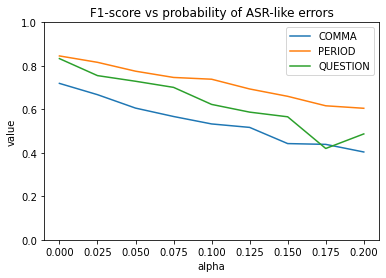

In [23]:
fig, ax = plt.subplots()
ax.plot(alphaList, COMMAprecision, label="COMMA")
ax.plot(alphaList, PERIODprecision, label="PERIOD")
ax.plot(alphaList, Qprecision, label="QUESTION")

ax.set_ylim([0, 1])

ax.set(xlabel='alpha', ylabel='value',
       title='Precision vs probability of ASR-like errors')

plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(alphaList, COMMArecall, label="COMMA")
ax.plot(alphaList, PERIODrecall, label="PERIOD")
ax.plot(alphaList, Qrecall, label="QUESTION")

ax.set_ylim([0, 1])

ax.set(xlabel='alpha', ylabel='value',
       title='Recall vs probability of ASR-like errors')

plt.legend()
plt.show()

fig, ax = plt.subplots()
ax.plot(alphaList, COMMAf1, label="COMMA")
ax.plot(alphaList, PERIODf1, label="PERIOD")
ax.plot(alphaList, Qf1, label="QUESTION")

ax.set_ylim([0, 1])

ax.set(xlabel='alpha', ylabel='value',
       title='F1-score vs probability of ASR-like errors')

plt.legend()
plt.show()

# Reconstruct text

In [24]:
def reconstructText(tokenList, Ypred, lenData, tokenizer, trueLabels=False):
    
    if trueLabels:
        noWindowYpred = np.array(Ypred)
        
    else:
        noWindowYpred = []

        for i in range(lenData):
            ylist, xlist = getIndexOfPrediction(i)
            predValues = []
            # add the prediction for each token
            for n in range(len(ylist)):
                predValues.append(Ypred[ylist[n]][xlist[n]])

            # take the mean of each prediction
            predValues = np.array(np.mean(predValues, axis=0))

            noWindowYpred.append(predValues)

        # select best class for each token
        noWindowYpred = np.array(noWindowYpred).argmax(axis=-1)

    # reconstructs text by detokenizing and applying the given labels
    tokens = tokenizer.convert_ids_to_tokens(tokenList)
    
    reconstructedText = ""
    for tok, label in zip(tokens, noWindowYpred):
        # no space in between if second token starts with '##'
        if tok.startswith("##"):
            reconstructedText += tok[2:]
        else:
            reconstructedText += " " + tok
        
        # add the punctuation from the label
        if label == LABEL_COMMA:
            reconstructedText += ","
        elif label == LABEL_PERIOD:
            reconstructedText += "."
        elif label == LABEL_QUESTION:
            reconstructedText += "?"
                
    reconstructedText = reconstructedText[1:] # skip the first space
    
    return reconstructedText

In [25]:
reconstructedTexts = []
for i in range(len(alphaList)):
    reconstructedTexts.append(reconstructText(ExpTokens[i], ExpOutputs[i], ExpLengths[i], tokenizer))

In [26]:
# true text
Xtrue, Ytrue, lenTrue = getPreparedDataset("test", False)
trueText = reconstructText(Xtrue, Ytrue, lenTrue, tokenizer, True)

In [27]:
print("TRUE:")
print(trueText[:600])
print()

for idx, text in enumerate(reconstructedTexts):
    print("alpha = " + "{:.{}f}".format(alphaList[idx],3))
    print(text[:600])
    print()

TRUE:
i ' m a savant, or more precisely, a high functioning autistic savant. it ' s a rare condition. and rarer still when accompanied, as in my case, by self awareness and a mastery of language. very often when i meet someone and they learn this about me there ' s a certain kind of awkwardness. i can see it in their eyes. they want to ask me something. and in the end, quite often, the urge is stronger than they are and they blurt it out, if i give you my date of birth, can you tell me what day of the week i was born on? or they mention cube roots or ask me to recite a long number or long text. i ho

alpha = 0.000
i ' m a savant, or more precisely, a high functioning autistic savant. it ' s a rare condition, and rarer still, when accompanied, as in my case, by self awareness and a mastery of language. very often when i meet someone and they learn this about me, there ' s a certain kind of awkwardness. i can see it in their eyes. they want to ask me something. and in the end, quite ofte